In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits,ascii
from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM
from scipy.constants import speed_of_light
import PCF
import pandas as pd
import healpy as hp
import treecorr
import matplotlib.gridspec as gridspec
from scipy import stats
from pynverse import inversefunc
import astropy.units as u
from astropy.cosmology import z_at_value
from Corrfunc.mocks.DDsmu_mocks import DDsmu_mocks
from Corrfunc.mocks.DDrppi_mocks import DDrppi_mocks
from Corrfunc.mocks.DDtheta_mocks import DDtheta_mocks
import itertools
from joblib import parallel_backend
from joblib import Parallel, delayed
from scipy.stats import binned_statistic,binned_statistic_2d
import numpy_indexed as npi


In [3]:
cosmo = FlatLambdaCDM(Om0=0.3089,H0=100)


In [ ]:
#calc = PCF.RSD_2PCF(Om0=0.3089)

#pathELG="/Users/rpaviot/eBOSSxDES/faizan/elg/eBOSS_ELG_SGC_pip_v7.dat.fits"
#pathELGr="/Users/rpaviot/eBOSSxDES/faizan/elg/eBOSS_ELG_SGC_pip_v7.rnd.fits"


pathELG="/Users/rpaviot/eBOSSxDES/faizan/lrg/eBOSS_LRG_SGC_pip_v7_2.dat.fits"
pathELGr="/Users/rpaviot/eBOSSxDES/faizan/lrg/eBOSS_LRG_SGC_pip_v7_2.ran.fits"

T = Table.read(pathELG)

"""Parent Catalog"""
rap = T['RA']
decp = T['DEC']
zp = T['Z']
wp = T['WEIGHT_SYSTOT']*T['WEIGHT_FKP']*T['WEIGHT_NOZ']
Dcp = cosmo.comoving_distance(zp).value



"""Fiber catalog"""
cond = np.where(T['FIBER']==1)
Tf= T[cond]
raf = Tf['RA']
decf = Tf['DEC']
zf = Tf['Z']
wf = Tf['WEIGHT_SYSTOT']*Tf['WEIGHT_FKP']*Tf['WEIGHT_NOZ']
wcpf = Tf['WEIGHT_CP']
Dcf = cosmo.comoving_distance(zp).value
W_BWf = Tf['WEIGHT_BW']
Nbitsf = int(W_BWf[0][0]).bit_length()*len(W_BWf[0])

"""Clustering catalog"""
cond = np.where((T['CLUSTERING']==1) & (T['Z'] > 0.6) & (T['Z'] < 1.1))

Tc = T[cond]
#Tc = Tc[0:1000]
ra = Tc['RA']
dec = Tc['DEC']
z = Tc['Z']
w = Tc['WEIGHT_SYSTOT']*Tc['WEIGHT_FKP']*Tc['WEIGHT_NOZ']
wcp = Tc['WEIGHT_CP']
Dc = cosmo.comoving_distance(z).value

"""WIIP apply only on DR pairs"""

W_BW = Tc['WEIGHT_BW']
Nbits = int(W_BW[0][0]).bit_length()*len(W_BW[0])



T2 = Table.read(pathELGr)
T2 = T2.to_pandas()

#cond = ((T2['Z'] > 0.6) & (T2['Z'] < 1.1))

#cond = ((T2['Z'] > 0.6) & (T2['Z'] < 1.0))

cond = ((T2['CLUSTERING']==1) & (T2['Z'] > 0.6) & (T2['Z'] < 1.1))
T2 = T2[cond]
T2= T2.sample(frac=0.4)
#x = np.column_stack((T2['RA'],T2['DEC'],T2['Z'],T2['WEIGHT_SYSTOT']*T2['WEIGHT_FKP']*T2['WEIGHT_NOZ'],T2['WEIGHT_CP'])).T
ra_r = T2['RA'].values
dec_r = T2['DEC'].values
z_r = T2['Z'].values
w_r = (T2['WEIGHT_FKP']*T2['WEIGHT_NOZ']*T2['WEIGHT_SYSTOT']).values
wcp_r = T2['WEIGHT_CP'].values
Dc_r = cosmo.comoving_distance(z_r).value
del T2
    



def IIP(x):
    count = (x & x)
    Nn = np.unpackbits(count.view('uint8'))
    return Nbits/np.sum(Nn)

def PIP(x,y):
    count = (x & y)
    Nn = np.unpackbits(count.view('uint8'))
    return Nbits/np.sum(Nn)


wIIP= np.array(list(map(IIP,W_BW)))
wIIPf= np.array(list(map(IIP,W_BWf)))



def distance(cent,pos):
    dist = np.sqrt((pos[:,0] - cent[0])**2+(pos[:,1] - cent[1])**2+(pos[:,2] - cent[2])**2)
    return dist
    
def norm(vec):
    return np.sqrt(vec[:,0]**2+vec[:,1]**2+vec[:,2]**2)

def normr(vec):
    return np.sqrt(vec[0]**2+vec[1]**2+vec[2]**2)


def all_pairs_mu(ind,r,w,size,binsfile,mubin):
    global count_smu,normDD
    cent = r[ind]
    wcent = w[ind]
    wi = w[int(ind+1):size]*wcent
    ri = r[int(ind+1):size]
    s = distance(cent,ri)
    los = (cent + ri)/2.
    ss = (cent - ri)
    los = los/norm(los)[:,None]
    ss = ss/norm(ss)[:,None]
    mu = abs(np.array([np.dot(x,y) for x,y in zip(los,ss)]))
    hist,_,_=np.histogram2d(s, mu, bins=(binsfile, mubin),weights=wi)
    count_smu = count_smu+hist
    normDD = normDD + np.sum(wi)


    
    
def all_pairs_mu_pip(i,r,w,W_BW,count_smu,normDD):
    cent = r[i]
    wcent = w[i]
    W_BWp = W_BW[i]
    wi = w[int(i+1):size]*wcent
    ri = r[int(i+1):size]
    W_BWi = W_BW[int(i+1):size]
    wpip = np.array(list(map(PIP,W_BWi,itertools.repeat(W_BWp))))
    s = distance(cent,ri)
    los = (cent + ri)/2.
    ss = (cent - ri)
    los = los/norm(los)[:,None]
    ss = ss/norm(ss)[:,None]
    mu = abs(np.array([np.dot(x,y) for x,y in zip(los,ss)]))
    hist,_,_=np.histogram2d(s, mu, bins=(binsfile, mubin),weights=wi*wpip)
    count_smu += hist 
    normDD += np.sum(wi)


def DD_brute_smu_parallel(*args,**qwargs):

    ra = args[0]
    dec = args[1]
    Dc = args[2]
    w =args[3].value
    binsfile = args[4]
    nmu = args[5]
    mubin = np.linspace(0,1,nmu+1)
    x = Dc*np.cos(dec*np.pi/180)*np.cos(ra*np.pi/180)
    y = Dc*np.cos(dec*np.pi/180)*np.sin(ra*np.pi/180)
    z = Dc*np.sin(dec*np.pi/180)
    r = np.column_stack([x,y,z])
    size = x.size
    indices = np.indices(x.shape)[0]
        
    count_smu = np.zeros((len(binsfile)-1,len(mubin)-1))
    normDD = 0  
    list(map(functools.partial(all_pairs_mu,r=r,w=w,size=size,binsfile=binsfile,\
                          mubin=mubin),indices))
    

    
    return normDD,count_smu


def DD_brute_smu(*args,**qwargs):
    ra = args[0]
    dec = args[1]
    Dc = args[2]
    w =args[3]
    binsfile = args[4]
    nmu = args[5]
    mubin = np.linspace(0,1,nmu+1)
    x = Dc*np.cos(dec*np.pi/180)*np.cos(ra*np.pi/180)
    y = Dc*np.cos(dec*np.pi/180)*np.sin(ra*np.pi/180)
    z = Dc*np.sin(dec*np.pi/180)
    r = np.column_stack([x,y,z])
    size = x.size
        
    count_smu = np.zeros((len(binsfile)-1,len(mubin)-1))
    normDD = 0
    
    for i in range(0,len(x)):
        cent =  r[i]
        wcent = w[i]
        wi = w[int(i+1):size]*wcent
        ri = r[int(i+1):size]
        s = distance(cent,ri)
        los = (cent + ri)/2.
        ss = (cent - ri)
        normR = norm(ss)
        los = los/norm(los)[:,None]
        ss = ss/norm(ss)[:,None]
        mu = abs(np.array([np.dot(x,y) for x,y in zip(los,ss)]))
        hist,_,_=np.histogram2d(s, mu, bins=(binsfile, mubin),weights=wi)
        count_smu += hist
        normDD += np.sum(wi)
        
    return normDD,count_smu



def DD_brute_smu_PIP(*args,**qwargs):
    ra = args[0]
    dec = args[1]
    Dc = args[2]
    w =args[3]
    binsfile = args[4]
    nmu = args[5]
    W_BW = args[6]
    mubin = np.linspace(0,1,nmu+1)
    x = Dc*np.cos(dec*np.pi/180)*np.cos(ra*np.pi/180)
    y = Dc*np.cos(dec*np.pi/180)*np.sin(ra*np.pi/180)
    z = Dc*np.sin(dec*np.pi/180)
    r = np.column_stack([x,y,z])
    size = x.size
        
    count_smu = np.zeros((len(binsfile)-1,len(mubin)-1))
    normDD = 0
    
    for i in range(0,len(x)):
        cent = np.array([x[i],y[i],z[i]])
        wcent = w[i]
        W_BWp = W_BW[i]
        wi = w[int(i+1):size]*wcent
        ri = r[int(i+1):size]
        W_BWi = W_BW[int(i+1):size]
        s = distance(cent,ri)
        wpip = np.array(list(map(PIP,W_BWi,itertools.repeat(W_BWp))))
        los = (cent + ri)/2.
        ss = (cent - ri)
        los = los/norm(los)[:,None]
        ss = ss/norm(ss)[:,None]
        mu = abs(np.array([np.dot(x,y) for x,y in zip(los,ss)]))
        hist,_,_=np.histogram2d(s, mu, bins=(binsfile, mubin),weights=wi*wpip)
        count_smu += hist
        normDD += np.sum(wi*wpip)
        
    return normDD,count_smu


def DD_brute_rppi(*args,**qwargs):
    ra = args[0]
    dec = args[1]
    Dc = args[2]
    w =args[3]
    binsfile = args[4]
    pimax = args[5]
    pibin = np.linspace(0,pimax,pimax+1)
    x = Dc*np.cos(dec*np.pi/180)*np.cos(ra*np.pi/180)
    y = Dc*np.cos(dec*np.pi/180)*np.sin(ra*np.pi/180)
    z = Dc*np.sin(dec*np.pi/180)
    r = np.column_stack([x,y,z])
    size = x.size
        
    count_rppi = np.zeros((len(binsfile)-1,len(pibin)-1))
    normDD = 0
    
    for i in range(0,size-1):
        cent,wcent = r[i],w[i]
        wi = w[int(i+1):size]
        ri = r[int(i+1):size]

        s = distance(cent,ri)
        los = (cent + ri)/2.
        ss = (cent - ri)
        los = los/norm(los)[:,None]
        ss = ss/norm(ss)[:,None]
        mu = abs(np.array([np.dot(x,y) for x,y in zip(los,ss)]))
        pi = s*mu
        rp = np.sqrt(s**2 - pi**2)
        
        hist,_,_,_= binned_statistic_2d(rp,pi,wi*wcent,statistic='sum',bins=[binsfile,pibin])
        count_rppi += hist
        normDD += np.sum(wi*wcent)
        
    return normDD,count_rppi


def DD_brute_rppi_ANGPIP(*args,**qwargs):
    ra = args[0]
    dec = args[1]
    Dc = args[2]
    w =args[3]
    binsfile = args[4]
    pimax = args[5]
    W_BW = args[6]
    scaling = args[7]
    pibin = np.linspace(0,pimax,pimax+1)
    x = Dc*np.cos(dec*np.pi/180)*np.cos(ra*np.pi/180)
    y = Dc*np.cos(dec*np.pi/180)*np.sin(ra*np.pi/180)
    z = Dc*np.sin(dec*np.pi/180)
    r = np.column_stack([x,y,z])
    size = x.size
        
    count_rppi = np.zeros((len(binsfile)-1,len(pibin)-1))
    normDD = 0
    
    for i in range(0,size-1):
        cent,wcent,W_BWp = r[i],w[i],W_BW[i]
        wi = w[int(i+1):size]
        ri = r[int(i+1):size]
        W_BWi = W_BW[int(i+1):size]

        s = distance(cent,ri)
        los = (cent + ri)/2.
        ss = (cent - ri)
        los = los/norm(los)[:,None]
        ss = ss/norm(ss)[:,None]
        mu = abs(np.array([np.dot(x,y) for x,y in zip(los,ss)]))
        pi = s*mu
        rp = np.sqrt(s**2 - pi**2)
        
        new,indices = npi.group_by(W_BWi,np.arange(len(W_BWi)))
        N2 = np.array(list((map(PIP,new,itertools.repeat(W_BWp)))))
        wpip = np.hstack([np.repeat(x,len(y)) for x,y in zip(N2,indices)])
        rpx = np.hstack([rp[ind] for ind in indices])
        pix = np.hstack([pi[ind] for ind in indices])
        wix = np.hstack([wi[ind] for ind in indices])
        
        hist,_,_,_= binned_statistic_2d(rpx,pix,wix*wcent*wpip,statistic='sum',bins=[binsfile,pibin])
        count_rppi += scaling[:,None]*hist
        normDD += np.sum(wix*wcent*wpip)
        
    return normDD,count_rppi


def zeff_sample(*args,**qwargs):
    ra = args[0]
    dec = args[1]
    zt = args[2] 
    Dc = args[3]
    w =args[4]
    x = Dc*np.cos(dec*np.pi/180)*np.cos(ra*np.pi/180)
    y = Dc*np.cos(dec*np.pi/180)*np.sin(ra*np.pi/180)
    z = Dc*np.sin(dec*np.pi/180)
    r = np.column_stack([x,y,z])
    size = x.size
        
    zeff = 0
    
    for i in range(0,10000):
        cent,wcent,zcent = r[i],w[i],zt[i]
        wi = w[int(i+1):size]
        ri = r[int(i+1):size]
        zi = zt[int(i+1):size]
        s = distance(cent,ri)
        cond = np.where(s < 150)
        wii = wi[cond]
        zii = zi[cond]
        zmean = (zcent + zii)/2.
        zeff += np.sum(wii*wcent*zmean)/np.sum(wii*wcent)
        
    return zeff
    

def DD_brute_theta(*args,**qwargs):
    ra = args[0]
    dec = args[1]
    w =args[2]
    binsfile = args[3]

    x = np.cos(dec*np.pi/180)*np.cos(ra*np.pi/180)
    y = np.cos(dec*np.pi/180)*np.sin(ra*np.pi/180)
    z = np.sin(dec*np.pi/180)
    r = np.column_stack([x,y,z])
    r = r/norm(r)[:,None]
    size = x.size
        
    count_theta = np.zeros(len(binsfile)-1)
    normDD = 0
    
    for i in range(0,len(x)-1):
        cent,wcent = r[i],w[i]
        wi = w[int(i+1):size]
        ri = r[int(i+1):size]
        mu = np.dot(ri,cent)
        theta = np.arccos(mu)*180/np.pi
        hist,_,_= binned_statistic(theta,wi*wcent,statistic='sum',bins=binsfile)
        count_theta += hist
        normDD += np.sum(wi*wcent)
        
    return normDD,count_theta




    


def DD_brute_theta_PIP(*args,**qwargs):
    ra = args[0]
    dec = args[1]
    w =args[2]
    binsfile = args[3]
    W_BW = args[4]
    x = np.cos(dec*np.pi/180)*np.cos(ra*np.pi/180)
    y = np.cos(dec*np.pi/180)*np.sin(ra*np.pi/180)
    z = np.sin(dec*np.pi/180)
    r = np.column_stack([x,y,z])
    r = r/norm(r)[:,None]
    size = x.size
        
    count_theta = np.zeros(len(binsfile)-1)
    normDD = 0


    for i in range(0,size-1):
        cent,wcent,W_BWp = r[i],w[i],W_BW[i]
        wi = w[int(i+1):size]
        ri = r[int(i+1):size]
        W_BWi = W_BW[int(i+1):size]
        
        mu = np.dot(ri,cent)
        theta = np.arccos(mu)*180/np.pi
        new,indices = npi.group_by(W_BWi,np.arange(len(W_BWi)))
        N2 = np.array(list((map(PIP,new,itertools.repeat(W_BWp)))))
        wpip = np.hstack([np.repeat(x,len(y)) for x,y in zip(N2,indices)])
        thetax = np.hstack([theta[ind] for ind in indices])
        wix = np.hstack([wi[ind] for ind in indices])


        hist,_,_= binned_statistic(thetax,wix*wcent*wpip,statistic='sum',bins=binsfile)
        count_theta += hist
        normDD += np.sum(wix*wcent*wpip)
        
    return normDD,count_theta



In [ ]:
normDD_IIP = (np.sum(w*wIIP)**2 - np.sum((w*wIIP)**2))/2.


In [ ]:
np.savetxt("LRG_DR16_cp.dat",data_cp)
np.savetxt("rrLRG_DR16_cp.dat",rr_cp)

np.savetxt("LRG_DR16_IIP.dat",data_pip)
np.savetxt("rrLRG_DR16.dat",rr_pip)

In [22]:
rar,decr,zr,wr = np.loadtxt("rrLRG_DR16_cp.dat").T
rax,decx,zx,wx = np.loadtxt("LRG_DR16_IIP.dat").T
racp,deccp,zcp,wcp = np.loadtxt("LRG_DR16_cp.dat").T

Dc_r = cosmo.comoving_distance(zr).value
Dc = cosmo.comoving_distance(zx).value

normDD_cp = (np.sum(wcp)**2 - np.sum((wcp)**2))/2.
normDR_IIP = np.sum(wx)*np.sum(wr)
normDR_cp = np.sum(wcp)*np.sum(wr)
normRR_cp =  (np.sum(wr)**2 - np.sum((wr)**2))/2.


theta,scalingDD,scalingDR = np.loadtxt("./angular_count_linearbin_LRG_v7.dat").T

pi,rp,xi,DD,DR,RD,RR = np.loadtxt("./xirppi_LRG_cp_linear.dat").T
pi2,rp2,xi2,DD2,DR2,RD2,RR2 = np.loadtxt("./xirppi_LRG_IIP_linear.dat").T
DDn = np.loadtxt('./DDpairs_LRG_ANGPIP_linearbins.dat').T
DDn = DDn.flatten()

DR2 = DR2.reshape((600,600))
DR2 = DR2*scalingDR
DR2 = DR2.flatten()

In [23]:
xi2 = (DDn/RR2)*(normRR_cp) - 2*(DR2/RR2)*(normRR_cp/normDR_IIP) + 1.
xi = (DD/RR)*(normRR_cp/normDD_cp) - 2*(DR/RR)*(normRR_cp/normDR_cp) + 1.

In [24]:
snew = np.sqrt(rp**2 + pi**2)
munew = pi/snew

bin_r = np.linspace(0,150,31)
bin_mu  = np.arange(0.0,1.01,0.01)

centersmu = np.zeros(len(bin_mu) - 1)
for i in range(0,len(bin_mu)-1):
    centersmu[i] = 0.5*(bin_mu[i]+bin_mu[i+1]) 
    
centers = np.zeros(len(bin_r) - 1)
for i in range(0,len(bin_r)-1):
    centers[i] = 0.5*(bin_r[i]+bin_r[i+1]) 
    
    L0 = lambda x : 1
L2 =  lambda x : (1./2)*(3*x**2-1)  
L4 = lambda x : (35.0*x*x*x*x-30.0*x*x+3.0)/8.0

e0 = np.zeros(len(centers))
e2 = np.zeros(len(centers))
e4 = np.zeros(len(centers))


e02 = np.zeros(len(centers))
e22 = np.zeros(len(centers))
e42 = np.zeros(len(centers))

for i in range(0,len(centers)):
    cond = np.where((bin_r[i] < snew) &(snew < bin_r[i+1]))
    k = len(cond[0])
    #print(k)
    xinew = xi[cond]
    xinew2 = xi2[cond]
    mu_ = munew[cond]
    e0[i] = (np.pi*1./2)*np.sum(xinew*np.sqrt(1.-mu_**2))/k
    e2[i] = (np.pi*5./2)*np.sum(xinew*np.sqrt(1.-mu_**2)*L2(mu_))/k
    e4[i] = (np.pi*5./2)*np.sum(xinew*np.sqrt(1.-mu_**2)*L4(mu_))/k
    
    e02[i] = (np.pi*1./2)*np.sum(xinew2*np.sqrt(1.-mu_**2))/k
    e22[i] = (np.pi*5./2)*np.sum(xinew2*np.sqrt(1.-mu_**2)*L2(mu_))/k
    e42[i] = (np.pi*5./2)*np.sum(xinew2*np.sqrt(1.-mu_**2)*L4(mu_))/k

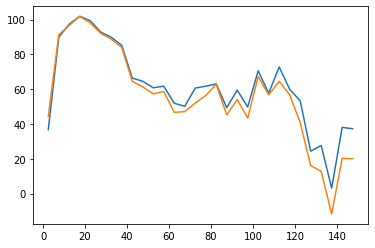

In [25]:
plt.plot(centers,e0*centers**2)
plt.plot(centers,e02*centers**2)

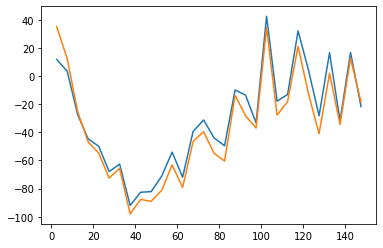

In [26]:
plt.plot(centers,e2*centers**2)
plt.plot(centers,e22*centers**2)